# Training VGG-11 on CIFAR-10
We will do the following steps in order.
1. Load and normalizing the CIFAR-10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

random_seed = 4332
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

## Dataset

Load and normalizing the CIFA10 training and test datasets using torchvision.

In [8]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

# TODO
# The output of torchvision datasets are PILImage images of range [0,1].
# Convert them to Tensors and normalize

# define train dataset transform
transform_train = transforms.Compose(
    [transforms.RandomCrop(size=32, padding=4), # random crop, size=32, padding=4
     transforms.RandomHorizontalFlip(p=0.5), # Random Horizontal Flip
     transforms.ToTensor(), # convert to tensor
     transforms.Normalize(mean, std) # normalize using dataset mean and std
    ])

# define test dataset transform
transform_test = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize(mean, std), # normalize using dataset mean and std
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(trainloader)
images, labels = dataiter.next()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50000
782
10000
torch.Size([64, 3, 32, 32])


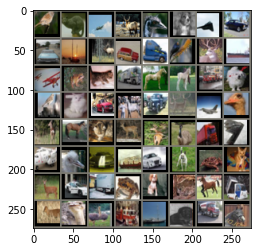

bird, cat, plane, deer, 


In [9]:
# display images
def imshow(img, std=std, mean=mean):
    img = img * std[:,None,None] + mean[:,None,None]  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(len(trainset))
print(len(trainloader)) # 50000 / 64
print(len(testset))
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(''.join('%s, ' % classes[labels[j]] for j in range(4)))

## Define VGG-11 network


* Network Model
    * Convolution - in_channels=3, out_channels=64, kernel_size=3, padding=1
    * Maxpoling2d - kernel_size=2, stride=2
    * Convolution - in_channels=64, out_channels=128, kernel_size=3, padding=1
    * Maxpoling2d - kernel_size=2, stride=2
    * Convolution - in_channels=128, out_channels=256, kernel_size=3, padding=1
    * Convolution - in_channels=256, out_channels=256, kernel_size=3, padding=1
    * Maxpoling2d - kernel_size=2, stride=2
    * Convolution - in_channels=256, out_channels=512, kernel_size=3, padding=1
    * Convolution - in_channels=512, out_channels=512, kernel_size=3, padding=1
    * Maxpoling2d - kernel_size=2, stride=2
    * Convolution - in_channels=512, out_channels=512, kernel_size=3, padding=1
    * Convolution - in_channels=512, out_channels=512, kernel_size=3, padding=1
    * Maxpoling2d - kernel_size=2, stride=2
    * Fully connected layer - in_features: 512, out_features: 10


* You can use `VGG.make_conv_relu` function.
* Apply ReLU activation function for hidden layers.
* Do not apply softmax activation function for the output layer.
    * softmax activation function are included in the loss function.


In [10]:
# TODO
class VGG(nn.Module):

    def __init__(self):
        super(VGG, self).__init__()
        # TODO
#         self.conv1_1 = nn.Conv2d(3, 64)
#         self.relu = nn.ReLU()
        
        self.conv1_1 = self.make_conv_relu(3, 64)
        self.conv2_1 = self.make_conv_relu(64, 128)
        self.conv3_1 = self.make_conv_relu(128, 256)
        self.conv3_2 = self.make_conv_relu(256, 256)
        self.conv4_1 = self.make_conv_relu(256, 512)
        self.conv4_2 = self.make_conv_relu(512, 512)
        self.conv5_1 = self.make_conv_relu(512, 512)
        self.conv5_2 = self.make_conv_relu(512, 512)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu = nn.ReLU(inplace=True)

#         original classifier in VGG-11, unused in CIFAR-10
#         self.classifier = nn.Sequential(
#             nn.Linear(7 * 7 * 512, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes),
#         )
        self.classifier = nn.Linear(512, 10)

#     def make_conv_relu(self, in_channels, out_channel):
#         layers = []
#         layers += [nn.Conv2d(in_channels, out_channel, kernel_size=3, padding=1),
#                    nn.ReLU(inplace=True)]
#         return nn.Sequential(*layers)
    
    def make_conv_relu(self, in_channels, out_channel):
        return nn.Sequential(nn.Conv2d(in_channels, out_channel, kernel_size=3, padding=1),
                              nn.ReLU(inplace=True)
                            )

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.maxpool(x)

        x = self.conv2_1(x)
        x = self.maxpool(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.maxpool(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.maxpool(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.maxpool(x)


        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x
    
net = nn.DataParallel(VGG()).to(device)

## Training

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use SGD with learning rate 0.01 and momentum 0.9

In [11]:
# TODO
loss_obj = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=1e-4)

## Train the network on the training data

In [12]:
net.train()

print('Start Training ')
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward
        outputs = net(inputs)
        loss = loss_obj(outputs, labels)
        
        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('\r[Epoch {}/{}][itr {}/{}] Loss: {}'.format(epoch+1, num_epochs, i+1, len(trainloader), running_loss/(i+1)), end='')

print('Finished Training')

Start Training 
[Epoch 10/10][itr 782/782] Loss: 0.5439750635829728Finished Training


## Testing

### Show network prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


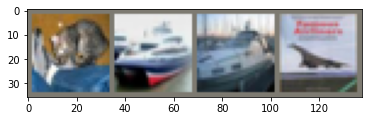

GrondTruth:    cat  ship  ship plane


In [13]:
net.eval()

# display ground truth
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
# display predicted
with torch.no_grad():
    outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1) # 확률(?)을 알고 싶을경우 여기 softmax를 넣어야함

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


### Test the network on the test data

#### Accuracy

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


#### Accuracy of each class

In [16]:
class_correct = [0.0] * 10
class_total = [0.0] * 10
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 92 %
Accuracy of  bird : 63 %
Accuracy of   cat : 57 %
Accuracy of  deer : 90 %
Accuracy of   dog : 73 %
Accuracy of  frog : 90 %
Accuracy of horse : 84 %
Accuracy of  ship : 91 %
Accuracy of truck : 88 %
